In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
print(tf.__version__)

2.7.0


In [ ]:
# url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

# dataset = tf.keras.utils.get_file("aclImdb_v1", url,
#                                     untar=True, cache_dir='.',
#                                     cache_subdir='')

# dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [2]:
dataset_dir = './aclImdb'

In [3]:
# os.listdir(dataset_dir)
train_dir = os.path.join(dataset_dir, 'train')
# print(os.listdir(os.path.join(train_dir, 'pos')))

sample_file = os.path.join(train_dir, 'pos/2140_10.txt')
with open(sample_file) as f:
  print(f.read())

Absolutely stunning, warmth for the head and the heart. The kind of movie western movie makers are too rushed, too frenetic to even attempt. My kids watched it, and they loved it too. What real people--goes to show you how cultural differences (the Japanese setting) is less important than the human similarities. Go see it, whether you like dancing or not.


In [10]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [5]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [8]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [12]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [13]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [14]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [15]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />T

In [16]:
def getvocab(i):
    print(" %d ---> "%i,vectorize_layer.get_vocabulary()[i])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))
for i in [7, 4, 1233, 1021]:
    getvocab(i)

Vocabulary size: 10000
 7 --->  is
 4 --->  a
 1233 --->  tough
 1021 --->  cop


In [17]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [20]:
embedding_dim = 16

model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

In [21]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [22]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
 56/625 [=>............................] - ETA: 1s - loss: 0.6918 - binary_accuracy: 0.5257

2021-12-08 17:58:42.296325: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


625/625 [==============================] - 3s 4ms/step - loss: 0.6630 - binary_accuracy: 0.6879 - val_loss: 0.6141 - val_binary_accuracy: 0.7726
Epoch 2/10
625/625 [==============================] - 2s 3ms/step - loss: 0.5482 - binary_accuracy: 0.8015 - val_loss: 0.4984 - val_binary_accuracy: 0.8222
Epoch 3/10
625/625 [==============================] - 2s 3ms/step - loss: 0.4446 - binary_accuracy: 0.8451 - val_loss: 0.4201 - val_binary_accuracy: 0.8482
Epoch 4/10
625/625 [==============================] - 2s 3ms/step - loss: 0.3781 - binary_accuracy: 0.8670 - val_loss: 0.3735 - val_binary_accuracy: 0.8622
Epoch 5/10
625/625 [==============================] - 2s 3ms/step - loss: 0.3354 - binary_accuracy: 0.8795 - val_loss: 0.3444 - val_binary_accuracy: 0.8684
Epoch 6/10
625/625 [==============================] - 2s 3ms/step - loss: 0.3040 - binary_accuracy: 0.8891 - val_loss: 0.3255 - val_binary_accuracy: 0.8726
Epoch 7/10
625/625 [==============================] - 2s 3ms/step - loss: 0

In [23]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 1s 2ms/step - loss: 0.3099 - binary_accuracy: 0.8737
Loss:  0.3098873198032379
Accuracy:  0.8737199902534485


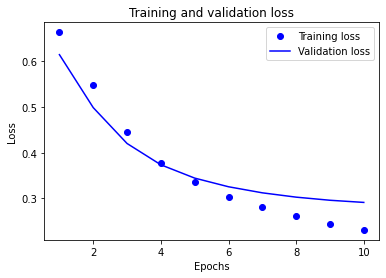

In [24]:
history_dict = history.history
history_dict.keys()
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

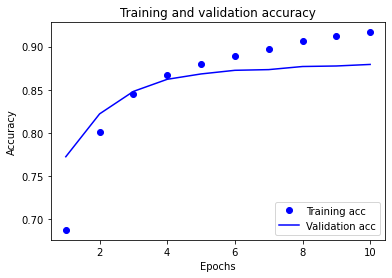

In [25]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [26]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 3s 4ms/step - loss: 0.3099 - accuracy: 0.8737
0.8737199902534485


In [35]:
export_model.predict([
    "rantong has cute little feet",
    "rantong ignores me"
])

array([[0.58289284],
       [0.5098302 ]], dtype=float32)